In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic

Check if there are null values:

In [4]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* Cabin has more than 75% of null values. Let's ignore it for now.
* Embarked has only 2 nulls. That will be an easy fix.
* Age has almost 20% of null values. Let's see what we can do with it. Maybe replace with median age?

Check numerical attributes:

In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 38% survived.
* The mean fare was £32.20.
* The mean age was almost 30 years old.

Double checking the target:

In [6]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Check the categorical attributes:

In [7]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

* C = Cherbourg
* Q = Queenstown
* S = Southampton

In [10]:
X_train = train_data.drop('Survived', axis=1)
y_train = train_data["Survived"]

Building our preprocessing pipelines:

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

# this class will impute the most frequent value for categorical values
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [12]:
# this class will allow us to select specific attributes from the DataFrame
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

num_attribs = ["Age", "SibSp", "Parch", "Fare"]

num_pipeline = Pipeline([("select_numeric", DataFrameSelector(num_attribs)),
                         ('imputer', SimpleImputer(strategy="median"))
                        ])

In [14]:
cat_attribs = ["Pclass", "Sex", "Embarked"]

cat_pipeline = Pipeline([("imputer", MostFrequentImputer()),
                         ("cat_encoder", OneHotEncoder()),
                        ])

In [15]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", cat_pipeline, cat_attribs),
                                  ])

In [16]:
X_train = full_pipeline.fit_transform(X_train)

In [17]:
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Now, let's start training.

SVC

In [18]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = 'auto')
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

Now, make a prediction on the test set:

In [19]:
X_test = full_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

We can now generate a csv file, submit our prediction and cross our fingers that everything is alright.<br>
However, we didn't even scored our prediction, we have no idea what it looks like right now.<br>
Let's use cross-validation too see how we are doing:

In [20]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10, n_jobs = -1)
svm_scores.mean()

0.7329588014981274

73%... well, this is better than just guessing.<br>
But what if we tried to improve our scores?

RandomForestClassifier:

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(X_train, y_train)

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv = 10, n_jobs = -1)
forest_scores.mean()

0.8126466916354558

Great! We've improved by almost 10% just by selecting another classifier.

Let's plot our previous scores in two box plots too see the scores distributions.
This plot help us visualize the outliers.

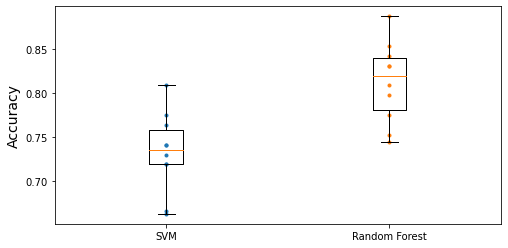

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Room for improvement:
* Compare many more models and tune hyperparameters using cross validation and grid search
* Do more feature engineering, for example:
    * replace SibSp and Parch with their sum
    * try to identify parts of names that correlate well with the Survived attribute (e.g. if the name contains "Countess", then survival seems more likely)
* try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [23]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [24]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


Let's submit our results to see how we score against the leaderboard!<br>
Regardless of the outcom, later we will come back and try to improve our results.

In [25]:
# Make a prediction using the RandomForestClassifier model on the wanted columns
predictions = forest_clf.predict(X_test)

In [26]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [27]:
# Confirm that the submission has the same size as the test set"

if len(submission) == len(test_data):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [28]:
submission.to_csv('RFC_titanic_submission.csv', index=False)

submissions_check = pd.read_csv('RFC_titanic_submission.csv')
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>